# 🏀 Predicción NBA 2026 — Exploración Inicial (EDA)

En este notebook realizamos la exploración inicial de los datos descargados desde el
API oficial de la NBA (stats.nba.com) utilizando `nba_api`.

**Objetivos de esta etapa:**
1. Cargar los logs de la temporada actual (TEAM-GAME).
2. Construir un dataset a nivel PARTIDO (HOME vs AWAY en una sola fila).
3. Realizar una exploración inicial:
   - ¿Cuántos partidos han ocurrido?
   - ¿Cómo se distribuyen los puntos?
   - ¿Qué diferencias existen entre local y visitante?
4. Crear los *targets* principales:
   - Puntos del equipo local (`HOME_PTS`)
   - Margen de victoria (`MARGIN_HOME`)
   - Puntos totales del partido (`TOTAL_POINTS`)
5. Detectar posibles problemas en los datos (duplicados, NA, formatos, etc.).

Este notebook forma parte del proyecto **Predicción NBA 2026**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_fetch import (
    get_current_season_team_logs,
    build_game_level_dataset
)

## 📥 Cargar datos oficiales desde la API de la NBA

Usaremos `get_current_season_team_logs()` para obtener todos los registros TEAM-GAME
y luego `build_game_level_dataset()` para pasarlo a nivel PARTIDO.


In [2]:
df_team_logs = get_current_season_team_logs()
df_team_logs.columns


Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [3]:
df_team_logs = get_current_season_team_logs()
df_games = build_game_level_dataset(df_team_logs, max_games=12)
df_games.head()


,GAME_ID,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_TEAM_ABBR,HOME_PTS,AWAY_TEAM_ID,AWAY_TEAM_NAME,AWAY_TEAM_ABBR,AWAY_PTS,MARGIN_HOME,HOME_WIN
0,0022500001,2025-10-21,1610612760,Oklahoma City Thunder,OKC,125,1610612745,Houston Rockets,HOU,124,1,1
1,0022500002,2025-10-21,1610612747,Los Angeles Lakers,LAL,109,1610612744,Golden State Warriors,GSW,119,-10,0
2,0022500003,2025-10-22,1610612752,New York Knicks,NYK,119,1610612739,Cleveland Cavaliers,CLE,111,8,1
3,0022500004,2025-10-22,1610612742,Dallas Mavericks,DAL,92,1610612759,San Antonio Spurs,SAS,125,-33,0
4,0022500080,2025-10-22,1610612766,Charlotte Hornets,CHA,136,1610612751,Brooklyn Nets,BKN,117,19,1


## 🔍 1. Exploración básica del dataset `df_games`

En esta sección revisamos:

- Estructura del dataframe (`info()`)
- Número de registros y columnas
- Presencia de valores nulos
- Posibles filas duplicadas


In [4]:
df_games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   GAME_ID         12 non-null     object        
 1   GAME_DATE       12 non-null     datetime64[ns]
 2   HOME_TEAM_ID    12 non-null     int64         
 3   HOME_TEAM_NAME  12 non-null     object        
 4   HOME_TEAM_ABBR  12 non-null     object        
 5   HOME_PTS        12 non-null     int64         
 6   AWAY_TEAM_ID    12 non-null     int64         
 7   AWAY_TEAM_NAME  12 non-null     object        
 8   AWAY_TEAM_ABBR  12 non-null     object        
 9   AWAY_PTS        12 non-null     int64         
 10  MARGIN_HOME     12 non-null     int64         
 11  HOME_WIN        12 non-null     int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 1.3+ KB


### 1.1 Valores nulos y filas duplicadas


In [5]:
# Conteo de nulos por columna
df_games.isna().sum()


GAME_ID           0
GAME_DATE         0
HOME_TEAM_ID      0
HOME_TEAM_NAME    0
HOME_TEAM_ABBR    0
HOME_PTS          0
AWAY_TEAM_ID      0
AWAY_TEAM_NAME    0
AWAY_TEAM_ABBR    0
AWAY_PTS          0
MARGIN_HOME       0
HOME_WIN          0
dtype: int64

In [6]:
# Número de filas completamente duplicadas
df_games.duplicated().sum()


np.int64(0)

## 📊 2. Estadística descriptiva básica

Analizamos:

- Puntos del equipo local (`HOME_PTS`)
- Puntos del equipo visitante (`AWAY_PTS`)
- Margen de victoria del local (`MARGIN_HOME`)


In [7]:
df_games[["HOME_PTS", "AWAY_PTS", "MARGIN_HOME"]].describe()


,HOME_PTS,AWAY_PTS,MARGIN_HOME
count,12.000000,12.000000,12.000000
mean,120.416667,119.416667,1.000000
std,11.942729,7.925314,15.614678
min,92.000000,108.000000,-33.000000
25%,115.750000,115.500000,-3.250000
50%,122.000000,119.500000,4.000000
75%,128.250000,122.500000,9.250000
max,136.000000,138.000000,21.000000


## 📈 3. Distribuciones de puntos y margen

Visualizamos la distribución de:

- Puntos del local
- Puntos del visitante
- Margen del local

Esto nos ayuda a:

- Detectar valores atípicos
- Ver el rango típico de anotación
- Ver si el margen está centrado alrededor de 0 (partidos parejos)


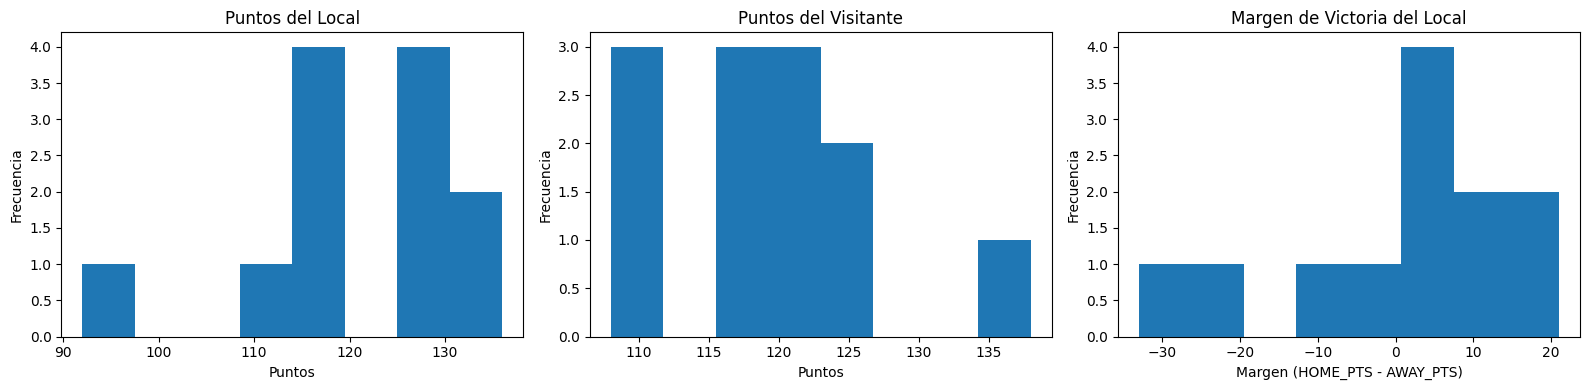

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.hist(df_games["HOME_PTS"], bins=8)
plt.title("Puntos del Local")
plt.xlabel("Puntos")
plt.ylabel("Frecuencia")

plt.subplot(1, 3, 2)
plt.hist(df_games["AWAY_PTS"], bins=8)
plt.title("Puntos del Visitante")
plt.xlabel("Puntos")
plt.ylabel("Frecuencia")

plt.subplot(1, 3, 3)
plt.hist(df_games["MARGIN_HOME"], bins=8)
plt.title("Margen de Victoria del Local")
plt.xlabel("Margen (HOME_PTS - AWAY_PTS)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


## 🏠 4. Balance de victorias del local (`HOME_WIN`)

Revisamos cuántas veces ha ganado el equipo local en los partidos descargados.


In [9]:
df_games["HOME_WIN"].value_counts()


HOME_WIN
1    8
0    4
Name: count, dtype: int64

In [10]:
df_games["HOME_WIN"].value_counts(normalize=True)


HOME_WIN
1    0.666667
0    0.333333
Name: proportion, dtype: float64

## 🎯 5. Creación de variables objetivo (targets)

Usaremos principalmente tres targets para nuestros futuros modelos de regresión:

1. **`HOME_PTS`** → Puntos del equipo local.
2. **`MARGIN_HOME`** → Diferencia de puntos a favor del local.
3. **`TOTAL_POINTS`** → Puntos totales del partido (`HOME_PTS + AWAY_PTS`).


In [11]:
# Puntos totales del partido
df_games["TOTAL_POINTS"] = df_games["HOME_PTS"] + df_games["AWAY_PTS"]

# Reordenamos columnas para que sea más legible
cols_order = [
    "GAME_ID", "GAME_DATE",
    "HOME_TEAM_ID", "HOME_TEAM_NAME", "HOME_TEAM_ABBR", "HOME_PTS",
    "AWAY_TEAM_ID", "AWAY_TEAM_NAME", "AWAY_TEAM_ABBR", "AWAY_PTS",
    "MARGIN_HOME", "HOME_WIN", "TOTAL_POINTS"
]

df_games = df_games[cols_order]
df_games.head()


,GAME_ID,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_TEAM_ABBR,HOME_PTS,AWAY_TEAM_ID,AWAY_TEAM_NAME,AWAY_TEAM_ABBR,AWAY_PTS,MARGIN_HOME,HOME_WIN,TOTAL_POINTS
0,0022500001,2025-10-21,1610612760,Oklahoma City Thunder,OKC,125,1610612745,Houston Rockets,HOU,124,1,1,249
1,0022500002,2025-10-21,1610612747,Los Angeles Lakers,LAL,109,1610612744,Golden State Warriors,GSW,119,-10,0,228
2,0022500003,2025-10-22,1610612752,New York Knicks,NYK,119,1610612739,Cleveland Cavaliers,CLE,111,8,1,230
3,0022500004,2025-10-22,1610612742,Dallas Mavericks,DAL,92,1610612759,San Antonio Spurs,SAS,125,-33,0,217
4,0022500080,2025-10-22,1610612766,Charlotte Hornets,CHA,136,1610612751,Brooklyn Nets,BKN,117,19,1,253


## 💾 6. Guardar dataset procesado

Guardamos el dataset resultante en la carpeta `data/processed/` para reutilizarlo
en los siguientes notebooks, sin necesidad de llamar nuevamente al API.


In [12]:
output_path = "../data/processed/games_2025_26_basic.csv"
df_games.to_csv(output_path, index=False)
output_path


'../data/processed/games_2025_26_basic.csv'

# ✅ Resumen del Notebook 01 — Exploración Inicial

En este notebook:

- Descargamos los datos oficiales de la temporada actual desde `stats.nba.com` usando `nba_api`.
- Convertimos el game log a un dataset a nivel **PARTIDO** (HOME vs AWAY en una fila).
- Exploramos:
  - Estructura del dataset (`info()`)
  - Nulos y duplicados
  - Estadísticos descriptivos de puntos y margen
  - Distribuciones básicas e indicador de victoria local
- Definimos los **targets** principales:
  - `HOME_PTS`
  - `MARGIN_HOME`
  - `TOTAL_POINTS`
- Guardamos el dataset procesado en `data/processed/games_2025_26_basic.csv`.

En el siguiente notebook (`02_feature_engineering.ipynb`) construiremos
features de **forma reciente, rachas y descanso**, que serán la base
para entrenar modelos de regresión más precisos.
